### Sources

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import HDBSCAN, KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Input, Flatten, Dense, Concatenate, Dropout, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

### Load Datasets

In [3]:
movie_data = pd.read_csv('./data/movies.csv') # movieId, title, genres
rating_data = pd.read_csv('./data/ratings.csv') # userId, movieId, rating, timestamp
tag_data = pd.read_csv('./data/tags.csv') # userId, movieId, tag, timestamp

### Merging the Datasets

In [4]:
rating_movie_data = pd.merge(rating_data, movie_data, on=['movieId'], how='left')
data = pd.merge(rating_movie_data, tag_data, on=['userId','movieId'], how='left')

# These unprocessed data will be used in the end to find titles and genres for recommended movies
unprocessed_data = data.copy()
unprocessed_data.drop(columns=['tag'], inplace=True)
unprocessed_data.drop(columns=['timestamp_y'], inplace=True)
unprocessed_data.drop(columns=['timestamp_x'], inplace=True)

data.head()

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,NaN,NaN
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,NaN,NaN
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,NaN,NaN
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,NaN,NaN


# Getting Familiar with the Data

In [5]:
data.describe()

,userId,movieId,rating,timestamp_x,timestamp_y
count,102677.000000,102677.000000,102677.000000,1.026770e+05,3.476000e+03
mean,327.761933,19742.712623,3.514813,1.209495e+09,1.323525e+09
std,183.211289,35884.400990,1.043133,2.170117e+08,1.731554e+08
min,1.000000,1.000000,0.500000,8.281246e+08,1.137179e+09
25%,177.000000,1199.000000,3.000000,1.019138e+09,1.138032e+09
50%,328.000000,3005.000000,3.500000,1.186590e+09,1.279956e+09
75%,477.000000,8366.000000,4.000000,1.439916e+09,1.498457e+09
max,610.000000,193609.000000,5.000000,1.537799e+09,1.537099e+09


We check for NaN rows in our features and we notice that the tags and their timestamps are mostly empty (99k in 100k dataset) so we will probably drop them later.

In [6]:
data.isna().sum()

userId             0
movieId            0
rating             0
timestamp_x        0
title              0
genres             0
tag            99201
timestamp_y    99201
dtype: int64

In [7]:
# Transforming the genres into a list for better modification later
data['genres'] = data['genres'].apply(lambda x: x.split('|'))
data.head(1)

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",NaN,NaN


In [8]:
# Listing all unique genres
genres_uq = set([genre for sublist in data['genres'] for genre in sublist])
genres_uq

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

### Plot for Genre Popularity among the Movies

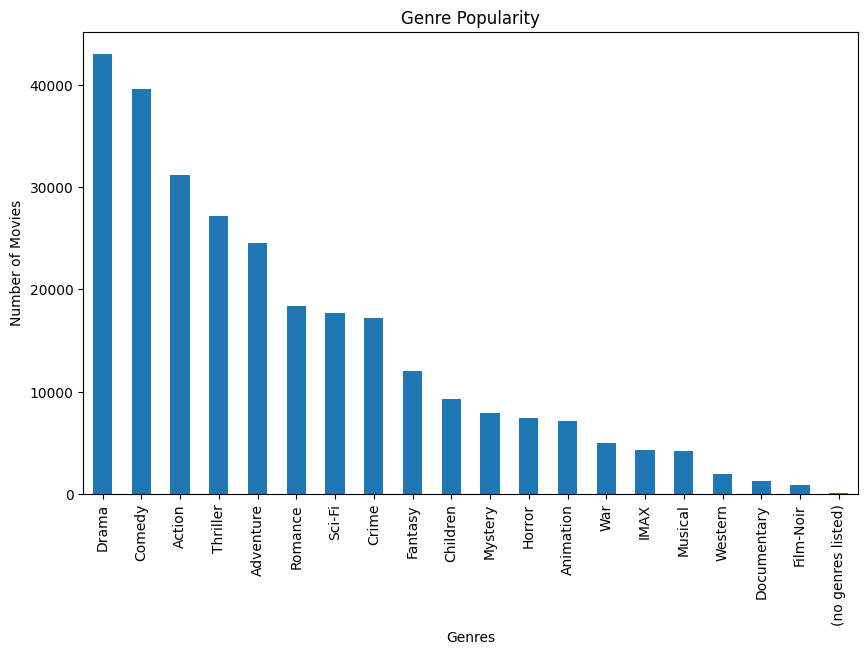

In [9]:
unique_movies = data.drop_duplicates(subset='movieId')
all_genres = [genre for sublist in data['genres'] for genre in sublist]

genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Genre Popularity')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()

### Plot of the Number of Ratings per Unique Rating

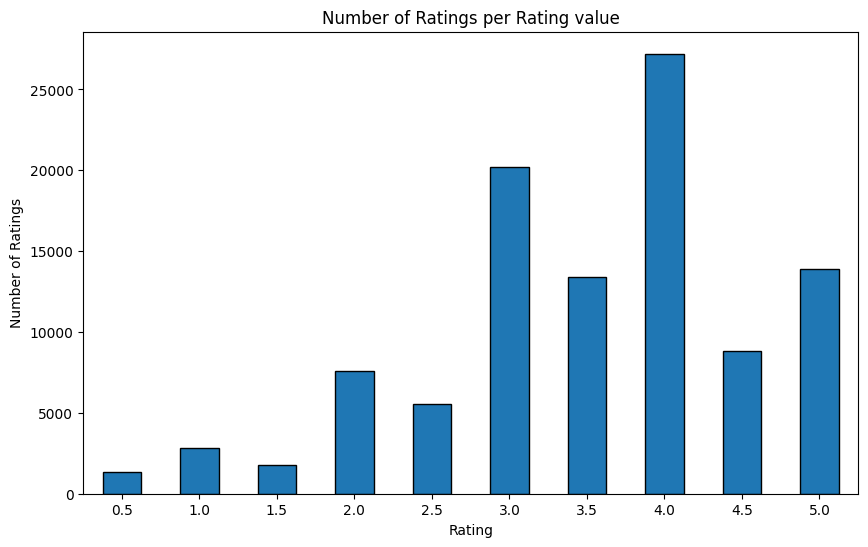

In [10]:
rating_counts = data['rating'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
rating_counts.plot(kind='bar', edgecolor='black')
plt.title('Number of Ratings per Rating value')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=0)
plt.show()

### Plot of the Unique Genres watched by User Count

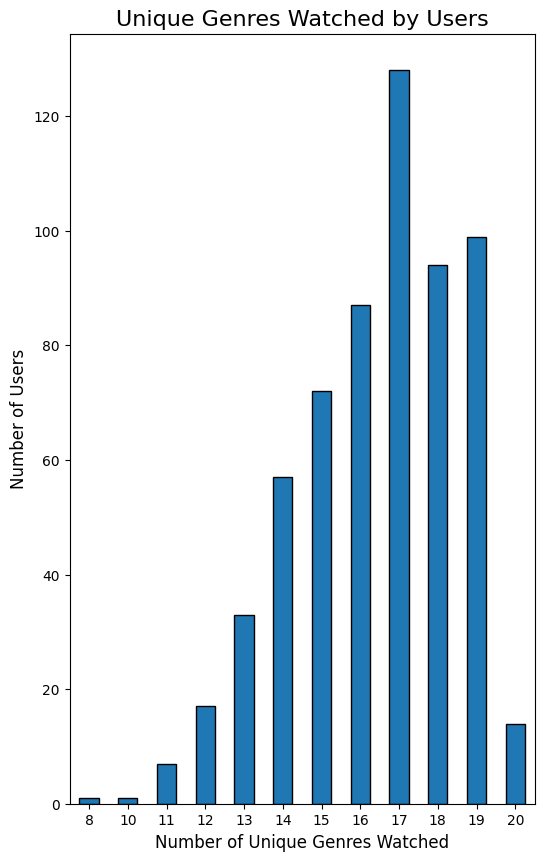

In [11]:
user_genres = {}

for _, row in data.iterrows():
    user_id = row['userId']
    movie_genres = row['genres']
    
    if user_id not in user_genres:
        user_genres[user_id] = set()
    user_genres[user_id].update(movie_genres)

unique_genres_watched = {user_id: len(genres) for user_id, genres in user_genres.items()}

user_genre_counts = pd.Series(unique_genres_watched)
user_genre_counts_freq = user_genre_counts.value_counts().sort_index()

plt.figure(figsize=(6, 10))
user_genre_counts_freq.plot(kind='bar', edgecolor='black')
plt.title('Unique Genres Watched by Users', fontsize=16)
plt.xlabel('Number of Unique Genres Watched', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=0)
plt.show()

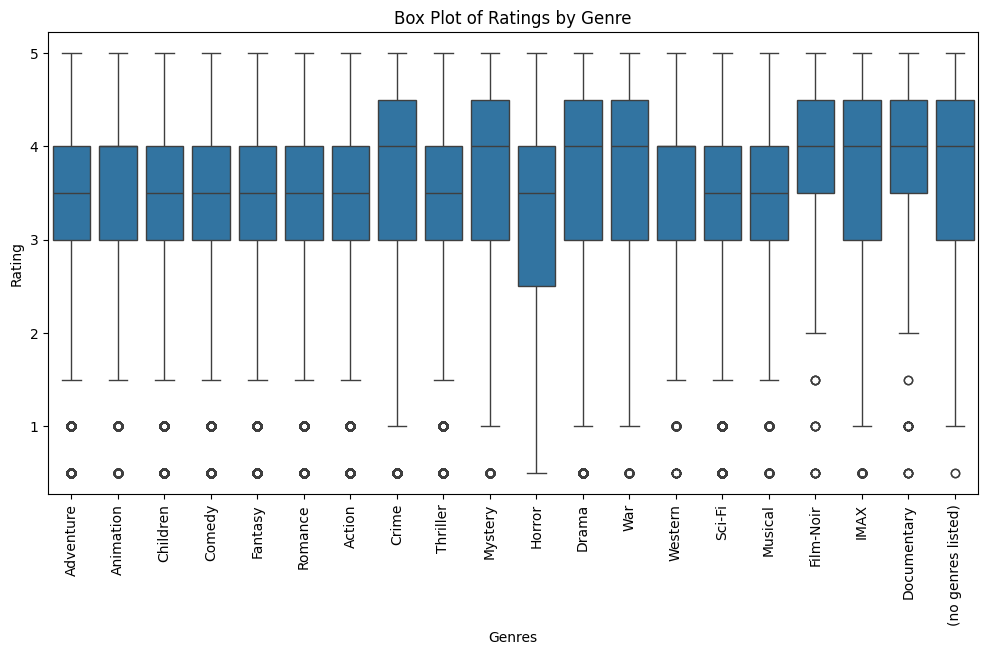

In [12]:
# BoxPlot genre and rating pairs
genre_ratings = data[['genres', 'rating']]
genre_ratings = genre_ratings.explode('genres')

plt.figure(figsize=(12, 6))
sns.boxplot(x='genres', y='rating', data=genre_ratings)
plt.title('Box Plot of Ratings by Genre')
plt.xlabel('Genres')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.show()

In this section we make a box plot to see how the movie genres correlate with each other. In order to do that we first one-hot encode the genres.

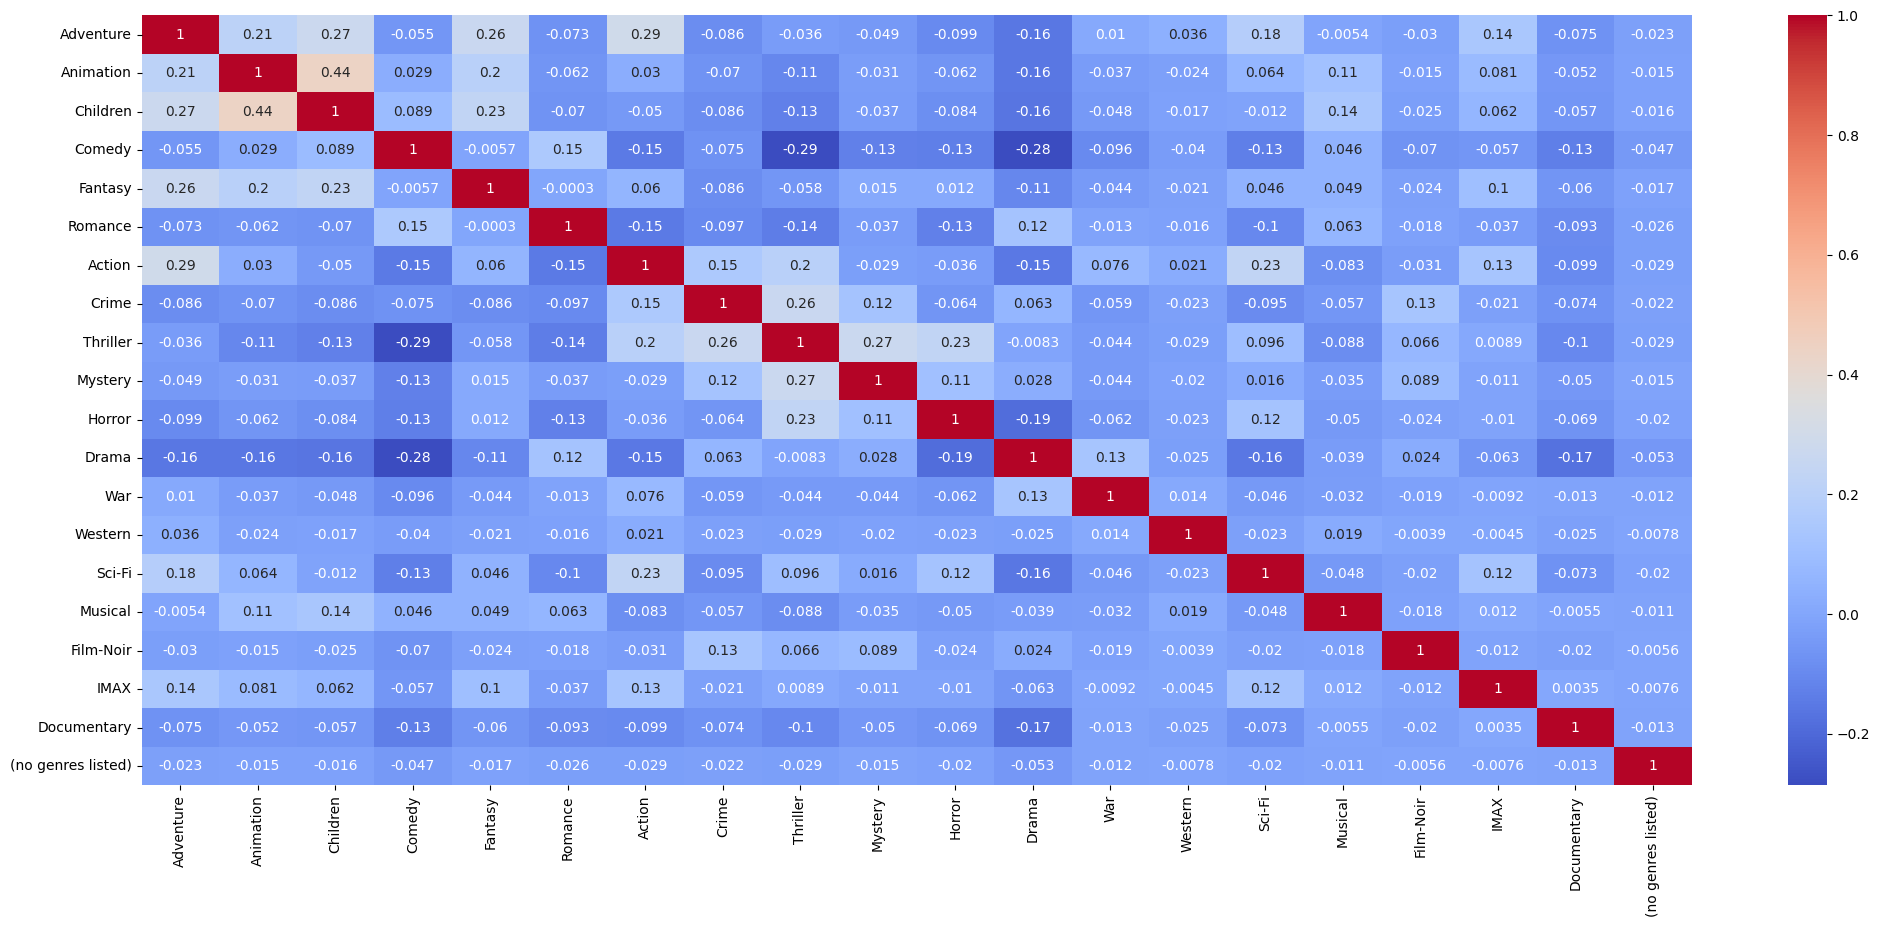

In [13]:
# This is a heatmap of how genres correlate with each other
unique_movies = data.drop_duplicates(subset='movieId')

# In order to make the heatmap we firstly have to one-hot encode the genres into binary columns
genre_onehot = unique_movies['genres'].apply(lambda x: pd.Series(1, index=x)).fillna(0)
genre_correlation = genre_onehot.corr()

plt.figure(figsize=(25, 10))
sns.heatmap(genre_correlation, cmap='coolwarm', annot=True)
plt.show()

# Data Pre-Processing

Dropping duplicate ratings (ratings that have more that one per user & movie)

In [14]:
data.drop_duplicates(subset=['userId', 'movieId'], keep='first', inplace=True)
data = data.reset_index(drop=True)

Movies are ~10k but their IDs go up to 193609. This will make things difficult for our model later so we need to reset their indexes to start from 1 while keeping a dictionary of the original IDs mapped to the new ones in order to be able to recommend movies.

In [15]:
unique_movie_ids = sorted(data['movieId'].unique())

movie_id_to_categorical = {original_id: new_id for new_id, original_id in enumerate(unique_movie_ids, start=1)}
data['movieId'] = data['movieId'].map(movie_id_to_categorical)

movie_dictionary = {categorical_id: original_id for original_id, categorical_id in movie_id_to_categorical.items()}

Splitting the title and the year into 2 different columns (features) because they are indeed different features and should not belong in the same column.

In [16]:
data['year'] = data['title'].str.strip().str[-5:].str.rstrip(')')
data.head()

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y,year
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",NaN,NaN,1995
1,1,3,4.0,964981247,Grumpier Old Men (1995),"[Comedy, Romance]",NaN,NaN,1995
2,1,6,4.0,964982224,Heat (1995),"[Action, Crime, Thriller]",NaN,NaN,1995
3,1,44,5.0,964983815,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",NaN,NaN,1995
4,1,47,5.0,964982931,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",NaN,NaN,1995


Dropping unnecessary columns:
* Movie Titles because they are misleading and do not give valuable information
* Tags and tag timestamps because almost all of them are NaN

In [17]:
# Drop the title, tag and tag timestamp column
data.drop(columns=['title'], inplace=True)
data.drop(columns=['tag'], inplace=True)
data.drop(columns=['timestamp_y'], inplace=True)

In [18]:
data.head()

,userId,movieId,rating,timestamp_x,genres,year
0,1,1,4.0,964982703,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,1,3,4.0,964981247,"[Comedy, Romance]",1995
2,1,6,4.0,964982224,"[Action, Crime, Thriller]",1995
3,1,44,5.0,964983815,"[Mystery, Thriller]",1995
4,1,47,5.0,964982931,"[Crime, Mystery, Thriller]",1995


### One-Hot encode and clean up the Genres

We one-hot encode the genres into different columns (features) instead of having a list of them in the same column because that will give better understanding to our model later.

In [19]:
for genre in genres_uq:
    data[genre] = data['genres'].apply(lambda row: 1.0 if genre in row else 0.0)

# Drop the (no genres listed) column
data.drop(columns=['(no genres listed)'], inplace=True)
data.drop(columns=['genres'], inplace=True)
data.head()

,userId,movieId,rating,timestamp_x,year,War,Children,Crime,Animation,Horror,...,Drama,IMAX,Musical,Adventure,Comedy,Fantasy,Film-Noir,Romance,Mystery,Action
0,1,1,4.0,964982703,1995,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1,3,4.0,964981247,1995,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1,6,4.0,964982224,1995,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,44,5.0,964983815,1995,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,47,5.0,964982931,1995,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Discretize Years into Decades

It is better to discretize the movie year of making into decades instead of having so many different values. It is also a logical discretization because movies from the same decade do not differ much, we are working with a real dataset here.

In [20]:
data['year'] = pd.to_numeric(data['year'], errors='coerce')

data['decade'] = (data['year'] // 10) * 10
data['decade'] = data['decade'].fillna(0).astype(int)
data['decade'] = data['decade'].astype(int)
data.drop(columns=['year'], inplace=True)

# Fill the movies with no year of making with default value 2000
data.loc[data['decade'] == 0, 'decade'] = 2000

data.head()

,userId,movieId,rating,timestamp_x,War,Children,Crime,Animation,Horror,Western,...,IMAX,Musical,Adventure,Comedy,Fantasy,Film-Noir,Romance,Mystery,Action,decade
0,1,1,4.0,964982703,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1990
1,1,3,4.0,964981247,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1990
2,1,6,4.0,964982224,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1990
3,1,44,5.0,964983815,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1990
4,1,47,5.0,964982931,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1990


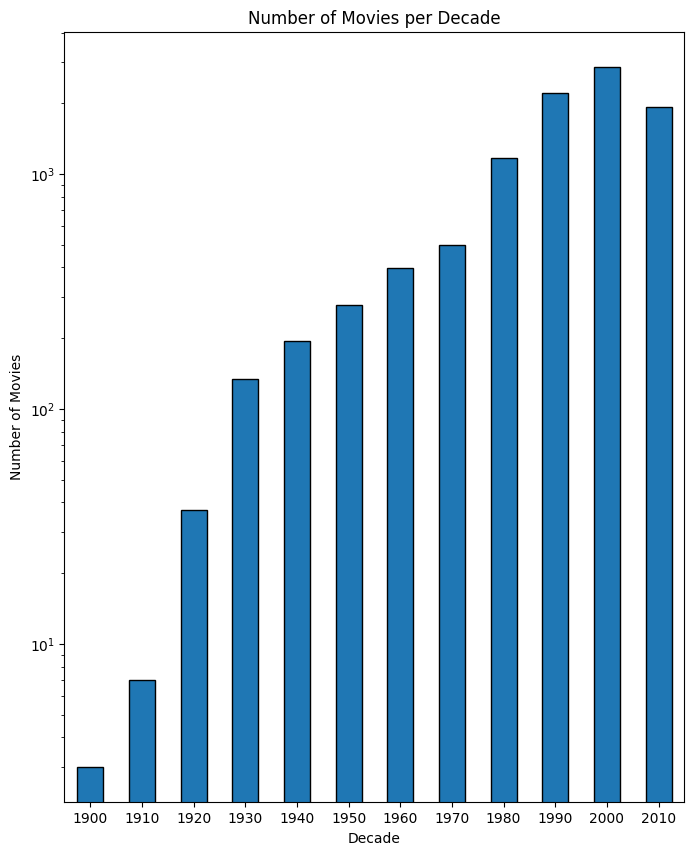

In [21]:
# Plot the number of movies per decade
unique_movies = data.drop_duplicates(subset='movieId')
rating_counts = unique_movies['decade'].value_counts().sort_index()

plt.figure(figsize=(8, 10))
rating_counts.plot(kind='bar', edgecolor='black')
plt.title('Number of Movies per Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Movies')
plt.yscale('log')
plt.xticks(rotation=0)
plt.show()

In [22]:
data.head()

,userId,movieId,rating,timestamp_x,War,Children,Crime,Animation,Horror,Western,...,IMAX,Musical,Adventure,Comedy,Fantasy,Film-Noir,Romance,Mystery,Action,decade
0,1,1,4.0,964982703,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1990
1,1,3,4.0,964981247,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1990
2,1,6,4.0,964982224,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1990
3,1,44,5.0,964983815,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1990
4,1,47,5.0,964982931,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1990


# Clustering

### Split to Train/Test Sets
1. The Train/Test split is random but we need to ensure that all users exist in both train and test sets in order to measure how well our recommendation system behaves to unseen movies for users, that is why we stratify the split based on the userId. Additionally, making recommendations for new users is out of scope.

2. We noticed that there are many movies that were only rated 1 time in the whole dataset, we also managed to include these ratings in our training set or else our model will have movies that it has never seen before and will have problem with the movie embedding and will also have hard time recommending those movies to new users.

In [23]:
one_sample_per_movie = data.groupby("movieId").first().reset_index()
remaining_data = data.drop(one_sample_per_movie.index)

# Split into train&test sets so that 85% of ratings per user are in the train set and the rest 15% on the test set
train_remaining, test = train_test_split(
    data,
    test_size=0.15,
    random_state=42,
    stratify=data["userId"]
)
train = pd.concat([train_remaining, one_sample_per_movie]).reset_index(drop=True)

scaler = StandardScaler()
train_dropped = train.drop(columns=['userId', 'movieId'], errors='ignore')
train_scaled_dropped = scaler.fit_transform(train_dropped)

Here are some splitting statistics for an overview of our data split.

In [24]:
# Check out the splitting metrics
train_users = set(train["userId"].unique())
test_users = set(test["userId"].unique())

users_in_both_sets = train_users & test_users
users_only_in_train_set = train_users - test_users
users_only_in_test_set = test_users - train_users

print(f"Total users: {len(train_users | test_users)}")
print(f"Users in both sets: {len(users_in_both_sets)}")
print(f"Unique users in train: {len(users_only_in_train_set)}")
print(f"Unique users in test: {len(users_only_in_test_set)}")

train_min_ratings = train.groupby("userId")["rating"].count().min()
test_min_ratings = test.groupby("userId")["rating"].count().min()

print(f"Minimum ratings per user in Train: {train_min_ratings}")
print(f"Minimum ratings per user in Test: {test_min_ratings}")

Total users: 610
Users in both sets: 610
Unique users in train: 0
Unique users in test: 0
Minimum ratings per user in Train: 17
Minimum ratings per user in Test: 3


### Normalize train/test sets

In [25]:
scaler = StandardScaler()

train_dropped = train.drop(columns=['userId', 'movieId'], errors='ignore')
train_scaled_dropped = scaler.fit_transform(train_dropped)

### Find the optimal K for K-Means

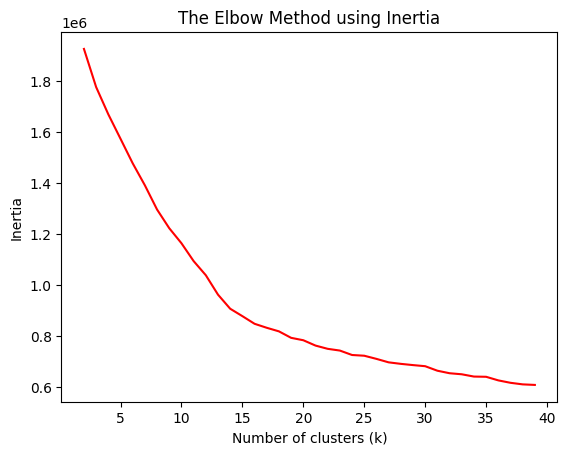

In [26]:
# Determine optimal K using Elbow Method
inertias = []
K = range(2, 40)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(train_scaled_dropped)
    inertias.append(kmeans.inertia_)

# Plot the Elbow Method
plt.plot(K, inertias, 'red')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

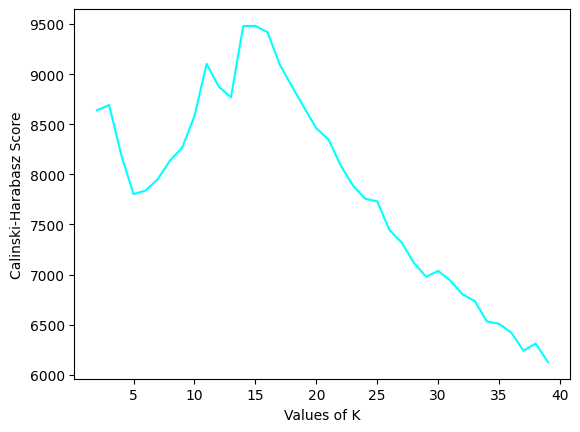

In [27]:
# Determine optimal K using Calinski-Harabasz Score
ch_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10).fit(train_scaled_dropped)
    ch_scores.append(calinski_harabasz_score(train_scaled_dropped, kmeans.predict(train_scaled_dropped)),)

plt.plot(K, ch_scores, 'cyan')
plt.xlabel('Values of K')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

### Apply K-Means

From the elbow method and the Calinski-Harabasz Score we can identify that the best cluster number is 15 for K-Means clustering

In [28]:
kmeans = KMeans(n_clusters=15, random_state=42, n_init=10)
clusters = kmeans.fit_predict(train_scaled_dropped)

### K-Means Evaluation

* `Silhouette Score` measures how well-separated the clusters are. It ranges from -1 to 1, where a higher Silhouette Score indicates better-defined and more meaningful clusters.
* `Davies-Bouldin Index` measures cluster compactness and separation. A lower DBI is better meaning:
    - < 1.0 → Excellent clustering (very compact and well-separated clusters).
    - 1.0 - 1.5 → Decent clustering, but room for improvement. 

    Unlike the Silhouette Score, DBI favors tight and distinct clusters. A DBI of 1.0-1.5 means

In [29]:
db_score_kmeans = davies_bouldin_score(train_scaled_dropped, clusters)
print(f"Davies-Bouldin Score with K-Means: {db_score_kmeans}")

silhouette_score_kmeans = silhouette_score(train_scaled_dropped, clusters)
print(f'Silhouette Score with K-Means: {silhouette_score_kmeans}')

Davies-Bouldin Score with K-Means: 1.3571736558073284
Silhouette Score with K-Means: 0.2021930982794786


### K-Means with PCA

We will also try redusing the dimensionality with PCA for the possibility of better results because the metrics showed that our clustering is not so good at this point...

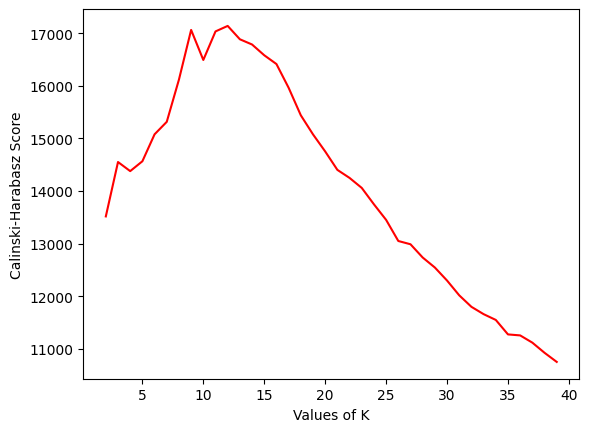

In [30]:
pca = PCA(n_components=10)
train_scaled_dropped_pca = pca.fit_transform(train_scaled_dropped)

# Determine optimal K using Calinski-Harabasz Score
ch_scores_pca = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(train_scaled_dropped_pca)
    ch_scores_pca.append(calinski_harabasz_score(train_scaled_dropped_pca, kmeans.predict(train_scaled_dropped_pca)),)

plt.plot(K, ch_scores_pca, 'red')
plt.xlabel('Values of K')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

In [31]:
kmeans_pca = KMeans(n_clusters=10, random_state=42, n_init=10)
clusters_pca = kmeans_pca.fit_predict(train_scaled_dropped_pca)

silhouette_score_pca_kmeans = silhouette_score(train_scaled_dropped_pca, clusters_pca)
db_score_pca_kmeans = davies_bouldin_score(train_scaled_dropped_pca, clusters_pca)

print(f"Davies-Bouldin Index with PCA and K-Means: {db_score_pca_kmeans}")
print(f"Silhouette Score with PCA and K-Means: {silhouette_score_pca_kmeans}")

Davies-Bouldin Index with PCA and K-Means: 1.1705494919793857
Silhouette Score with PCA and K-Means: 0.24347490629298693


After applying PCA we can see major improvement in our clustering based on the metrics.

In [32]:
train_kmeans = train.copy()
train_kmeans['cluster'] = clusters_pca
train_kmeans.head(10)

,userId,movieId,rating,timestamp_x,War,Children,Crime,Animation,Horror,Western,...,Musical,Adventure,Comedy,Fantasy,Film-Noir,Romance,Mystery,Action,decade,cluster
0,206,593,3.0,850763310,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1990,9
1,572,1864,4.0,946487152,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1980,1
2,500,1319,3.0,1005528017,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1990,7
3,249,7649,2.5,1346752763,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2010,2
4,452,1939,5.0,1013394715,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1990,9
5,18,6906,3.5,1455059693,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,2
6,11,431,3.0,902154805,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1990,2
7,354,396,3.5,1200870757,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1990,1
8,57,1096,3.0,965797285,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1990,7
9,603,1022,4.0,953925483,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1960,0


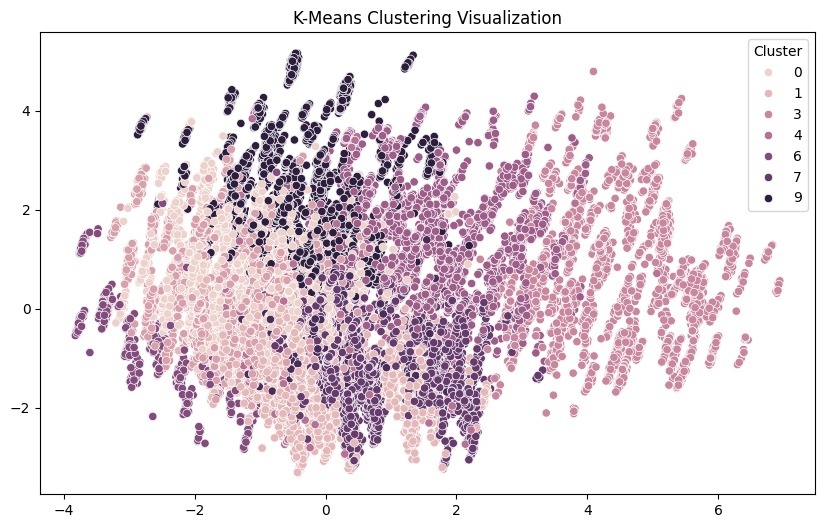

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_scaled_dropped_pca[:, 0], y=train_scaled_dropped_pca[:, 1], hue=clusters_pca)
plt.title("K-Means Clustering Visualization")
plt.legend(title="Cluster")
plt.show()

### HDBSCAN without PCA

### Optimal min_cluster_size
We will use Silhouette Score and Davies-Bouldin Index to find the optimal `min_cluster_size` value for HDBSCAN. We want the biggest Silhouette Score we can get in combination with the lowest Davies-Bouldin Index score while also not having many clusters because we only have 9700 movies and 600 users.

<u>Warning</u>: this cell is taking over 10 minutes to calculate

In [34]:
for min_clusters in [5, 10, 15, 20, 30, 50, 80]:
    hdbscan = HDBSCAN(min_cluster_size=min_clusters)
    clusters_hdbscan = hdbscan.fit_predict(train_scaled_dropped)

    # Filter out outlier cluster and labels
    valid_clusters = train_scaled_dropped[clusters_hdbscan != -1]
    valid_labels = clusters_hdbscan[clusters_hdbscan != -1]

    silhouette = silhouette_score(valid_clusters, valid_labels)
    db_score = davies_bouldin_score(valid_clusters, valid_labels)
    unique, counts = np.unique(clusters_hdbscan, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))
    
    num_noise = (clusters_hdbscan == -1).sum()
    total_points = len(clusters_hdbscan)
    noise_ratio = num_noise / total_points * 100

    print(f"min_cluster_size = {min_clusters} -> \n\t\tSilhouette Score: {silhouette} \n\t\tDBI Score: {db_score} \n\t\tSmallest Cluster Size: {min(cluster_sizes.values())} \n\t\tLargest Cluster Size: {max(cluster_sizes.values())} \n\t\tNo. of Clusters: {len(set(valid_labels))} \n\t\tNoise Points: {num_noise} / {total_points} ({noise_ratio:.2f}%)")

min_cluster_size = 5 -> 
		Silhouette Score: 0.6297897947193709 
		DBI Score: 0.5291622100358855 
		Smallest Cluster Size: 5 
		Largest Cluster Size: 20498 
		No. of Clusters: 7509 
		Noise Points: 20498 / 95434 (21.48%)
min_cluster_size = 10 -> 
		Silhouette Score: 0.5244771884398541 
		DBI Score: 0.7162260140445956 
		Smallest Cluster Size: 10 
		Largest Cluster Size: 23188 
		No. of Clusters: 2635 
		Noise Points: 23188 / 95434 (24.30%)
min_cluster_size = 15 -> 
		Silhouette Score: 0.4668783948409707 
		DBI Score: 0.7772573948330699 
		Smallest Cluster Size: 15 
		Largest Cluster Size: 23127 
		No. of Clusters: 1534 
		Noise Points: 23127 / 95434 (24.23%)
min_cluster_size = 20 -> 
		Silhouette Score: 0.42885184579313873 
		DBI Score: 0.8235000921376852 
		Smallest Cluster Size: 20 
		Largest Cluster Size: 22303 
		No. of Clusters: 1027 
		Noise Points: 22303 / 95434 (23.37%)
min_cluster_size = 30 -> 
		Silhouette Score: 0.39229950223120275 
		DBI Score: 0.9063844141314493 
		Smalles

### HDBSCAN with PCA

### Optimal min_cluster_size
We will use the same metrics as above to calculate the best minimum cluster size value again.

<u>Warning</u>: this cell is taking over 10 minutes to calculate

In [35]:
for min_clusters in [5, 10, 15, 20, 30, 50, 80]:
    hdbscan = HDBSCAN(min_cluster_size=min_clusters)
    clusters_hdbscan = hdbscan.fit_predict(train_scaled_dropped_pca)

    # Filter out outlier cluster and labels
    valid_clusters = train_scaled_dropped_pca[clusters_hdbscan != -1]
    valid_labels = clusters_hdbscan[clusters_hdbscan != -1]

    silhouette = silhouette_score(valid_clusters, valid_labels)
    db_score = davies_bouldin_score(valid_clusters, valid_labels)
    unique, counts = np.unique(clusters_hdbscan, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))
    
    num_noise = (clusters_hdbscan == -1).sum()
    total_points = len(clusters_hdbscan)
    noise_ratio = num_noise / total_points * 100

    print(f"min_cluster_size = {min_clusters} -> \n\t\tSilhouette Score: {silhouette} \n\t\tDBI Score: {db_score} \n\t\tSmallest Cluster Size: {min(cluster_sizes.values())} \n\t\tLargest Cluster Size: {max(cluster_sizes.values())} \n\t\tNo. of Clusters: {len(set(valid_labels))} \n\t\tNoise Points: {num_noise} / {total_points} ({noise_ratio:.2f}%)")

min_cluster_size = 5 -> 
		Silhouette Score: 0.6182550051014093 
		DBI Score: 0.5760530801208313 
		Smallest Cluster Size: 5 
		Largest Cluster Size: 21525 
		No. of Clusters: 7361 
		Noise Points: 21525 / 95434 (22.55%)
min_cluster_size = 10 -> 
		Silhouette Score: 0.4913366932909389 
		DBI Score: 0.7279896684721929 
		Smallest Cluster Size: 10 
		Largest Cluster Size: 23809 
		No. of Clusters: 2472 
		Noise Points: 23809 / 95434 (24.95%)
min_cluster_size = 15 -> 
		Silhouette Score: 0.43167105157425006 
		DBI Score: 0.7948462908888492 
		Smallest Cluster Size: 15 
		Largest Cluster Size: 24156 
		No. of Clusters: 1440 
		Noise Points: 24156 / 95434 (25.31%)
min_cluster_size = 20 -> 
		Silhouette Score: 0.39397378263130783 
		DBI Score: 0.8488720331593459 
		Smallest Cluster Size: 20 
		Largest Cluster Size: 24010 
		No. of Clusters: 949 
		Noise Points: 24010 / 95434 (25.16%)
min_cluster_size = 30 -> 
		Silhouette Score: 0.3600348140063471 
		DBI Score: 0.9214435791522236 
		Smallest

### Apply the Optimal HDBSCAN to our Dataset

Overall we need a balance between the cluster number and the metrics, we notice that smaller clusters have better metrics (which is logical) but this solution also makes too many clusters. Keeping that in mind we should have 10-20 `min_cluster_size` for a reasonable amount of clusters. We decided to keep `min_cluster_size = 20` which makes ~900 clusters while also still having good metrics and reduced noise.

<u>Note</u>: for every iteration the non-PCA HDBSCAN performs better clustering overall so we decided to keep the non-PCA HDBSCAN for our model clustering.

In [36]:
hdbscan = HDBSCAN(min_cluster_size=20)
clusters_hdbscan = hdbscan.fit_predict(train_scaled_dropped)

train_dbscan = train.copy()
train_dbscan['cluster'] = clusters_hdbscan

train_dbscan_sorted = train_dbscan.sort_values(by="cluster", ascending=False)
train_dbscan_sorted.head(10)

,userId,movieId,rating,timestamp_x,War,Children,Crime,Animation,Horror,Western,...,Musical,Adventure,Comedy,Fantasy,Film-Noir,Romance,Mystery,Action,decade,cluster
23767,32,48,3.0,856736227,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1990,1026
42406,541,244,3.0,835643551,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1990,1026
15116,102,473,3.0,835877244,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1990,1026
41906,109,320,3.0,841109369,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1990,1026
47594,565,473,3.0,846533399,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1990,1026
48952,133,473,3.0,843491579,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1990,1026
47982,411,473,3.0,835532588,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1990,1026
48229,321,473,3.0,843212642,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1990,1026
47232,402,48,3.0,849598217,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1990,1026
1098,476,320,3.0,835022275,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1990,1026


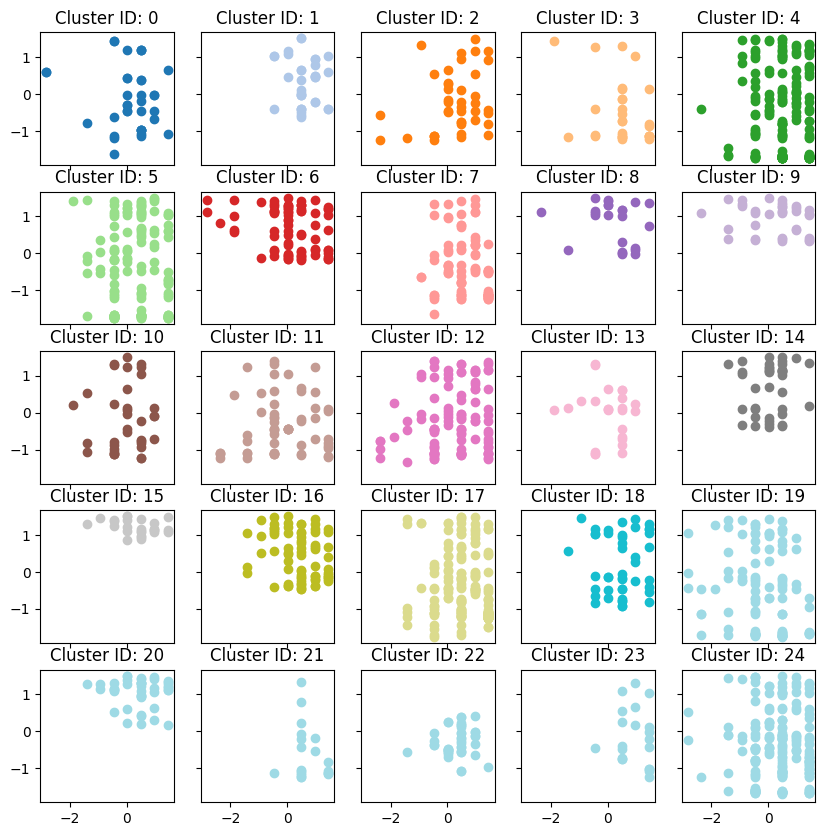

In [37]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10), sharex=True, sharey=True)
ax_flat = ax.flatten()

for i, cluster_id in enumerate(set(hdbscan.labels_)):
    if i == 25:
        break
    mask = hdbscan.labels_ == cluster_id
    ax_flat[i].scatter(train_scaled_dropped[mask, 0], train_scaled_dropped[mask, 1], color=plt.cm.tab20(cluster_id) if cluster_id != -1 else 'white')
    ax_flat[i].set_title(f'Cluster ID: {cluster_id}')

plt.show()

# Neural Networks

### Data Preparation

We decided to make a classifier model that predicts if a user will like a movie or not and we will use that output to calculate propabilities and sort them in order to recommend movies to users later.

Model Inputs: 
* userId
* movieId
* movie decade
* clusterId
* genres one-hot

Model output:
* 0 or 1 based on the rating (0 means the user did not like the movie, 1 means the user liked it)

In [39]:
test["cluster"] = np.zeros(len(test))

numerical = ["decade"]
genres = list(genres_uq)
genres.remove("(no genres listed)")

scaler = MinMaxScaler()
train_dbscan[numerical] = scaler.fit_transform(train_dbscan[numerical])
test[numerical] = scaler.transform(test[numerical])

X_train = [
    train_dbscan["userId"].values,
    train_dbscan["movieId"].values,
    train_dbscan[numerical + ["cluster"]].values,
    train_dbscan[genres].values
]
Y_train = (train_dbscan["rating"] >= 3.5).astype(int).values

X_test = [
    test["userId"].values,
    test["movieId"].values,
    test[numerical + ["cluster"]].values,
    test[genres].values
]
Y_test = (test["rating"] >= 3.5).astype(int).values

### Machine Learning Model

Initially we experienced overfitting in our model, our solutions were:
1. From 3 neuron layers of 64->32->16 we reduced it to 16->8 to remove complexity
2. `timestamp_x` feature which was the rating timestamp was adding too much noise so we removed it completely
3. Learning rate reduction to `0.0001`
4. Added 30% dropout to the first dense layer
5. Reduced the embeddings dimensions of 64 & 64 to 16 for users and 8 for movies
6. Reduced the training batch size from 64 to 32

In [40]:
num_users = train_dbscan["userId"].nunique()
num_movies = train_dbscan["movieId"].nunique()
num_numerical = len(numerical) + 1  # +1 for the clusters
num_genres = len(genres)

user_input = Input(shape=(1,), name="user_input")
user_embedding = Embedding(input_dim=num_users + 1, output_dim=16, name="user_embedding")(user_input)
user_flat = Flatten()(user_embedding)

movie_input = Input(shape=(1,), name="movie_input")
movie_embedding = Embedding(input_dim=num_movies + 1, output_dim=8, name="movie_embedding")(movie_input)
movie_flat = Flatten()(movie_embedding)

numerical_input = Input(shape=(num_numerical,), name="numerical_input")
genre_input = Input(shape=(num_genres,), name="genre_input")

input_concat = Concatenate()([user_flat, movie_flat, numerical_input, genre_input])

x = Dense(16, activation="relu")(input_concat)
x = Dropout(0.3)(x)
x = Dense(8, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[user_input, movie_input, numerical_input, genre_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### Model Training

For model training we added an early stop if the validation loss starts increasing which means the training has reached it's limit capacity and will start overfitting. Four epochs patience and if the valdation loss does not reduce anymore we stop the training and restore the best weights.

Epoch 1/50
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 3s 977us/step - accuracy: 0.5696 - loss: 10.1482 - val_accuracy: 0.4289 - val_loss: 0.7039
Epoch 2/50
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5154 - loss: 1.3386 - val_accuracy: 0.4539 - val_loss: 0.6944
Epoch 3/50
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step - accuracy: 0.5354 - loss: 0.7933 - val_accuracy: 0.6310 - val_loss: 0.6716
Epoch 4/50
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 2s 960us/step - accuracy: 0.6398 - loss: 0.6882 - val_accuracy: 0.6369 - val_loss: 0.6521
Epoch 5/50
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 2s 939us/step - accuracy: 0.6515 - loss: 0.6528 - val_accuracy: 0.6413 - val_loss: 0.6405
Epoch 6/50
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 2s 961us/step - accuracy: 0.6576 - loss: 0.6380 - val_accuracy: 0.6446 - val_loss: 0.6331
Epoch 7/50
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 2s 953us/step - accuracy: 0.6649 - loss: 0.6277 - val_accuracy: 0.6494 - val_loss: 0.6274
Epoch 8/50
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 2s 987us/step - accuracy: 0.6704 - 

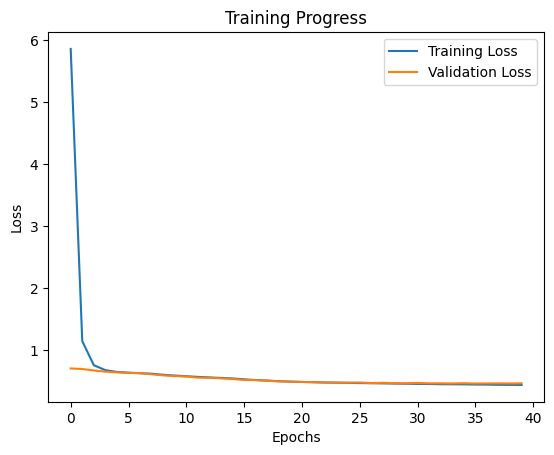

In [41]:
early_stop = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

training = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=50,
    verbose=1,
    shuffle=True,
    callbacks=[early_stop]
)

plt.plot(training.history["loss"], label="Training Loss")
plt.plot(training.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Progress")
plt.legend()
plt.show()

As long as we used the clusters as an input feature to our model that means we need to provide it during testing but the cluster labels for the test set are not available. So we need a method to kind of predict the cluster of each user and assign it to each test row. In order to do that we extracted the user and movie embeddings and found the centroid of each cluster based on the embeddings average. In simpler terms, we just find the closest cluster for each user based on the model embeddings. This might not be the best way to predict clusters but it is doing a pretty good job because initially we assigned clusters based on which cluster the user appears the most times and that model was a lot worse.

In [42]:
user_embedding_matrix = model.get_layer("user_embedding").get_weights()[0]
movie_embedding_matrix = model.get_layer("movie_embedding").get_weights()[0]

user_cluster_data = train_dbscan[["userId", "cluster"]].drop_duplicates()
user_cluster_data["embedding"] = user_cluster_data["userId"].apply(lambda x: user_embedding_matrix[x])

# Compute the centroid of each cluster using the average embeddings per cluster
cluster_centroids = (
    user_cluster_data.groupby("cluster")["embedding"]
    .apply(lambda x: np.mean(np.stack(x), axis=0))
    .to_dict()
)

def predict_cluster_from_embedding(user_id):
    user_vector = user_embedding_matrix[user_id].reshape(1, -1)

    # Compute distances to all centroids
    cluster_distances = {cid: np.linalg.norm(user_vector - centroid) for cid, centroid in cluster_centroids.items()}

    # Return the closest cluster
    return min(cluster_distances, key=cluster_distances.get)

# Apply cluster inference
test["cluster"] = test["userId"].apply(predict_cluster_from_embedding)

### Metrics

* An accuracy of 82.91% suggests that the model performs well and can classify a majority of the test instances correctly.
* A loss of 46% in binary cross-entropy indicates a moderate error margin. While not perfect, it suggests that the model is making reasonably accurate predictions.

<u>Note</u>: These values might vary per run because of the training shuffling, but they will not be too off.

In [43]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.7115 - loss: 0.6070


In the confusion matrix we can see that the model has a hard time to identify what the users do not like but is very good into identifying what the users will actually like. This is not a problem because we want to recommend movies that the users will like so the true positive liked movies will have bigger weights that the false positive ones.

473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step


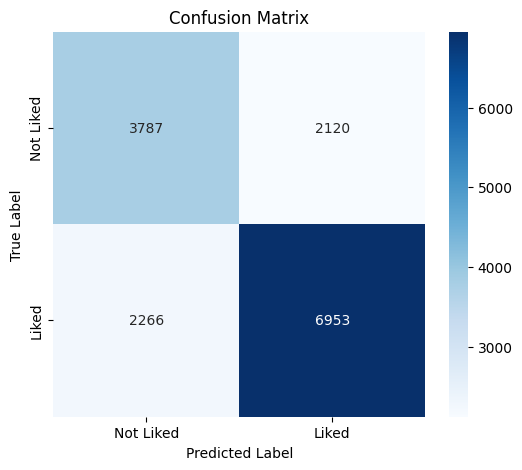

In [44]:
y_predictions = model.predict(X_test)
y_predictions_classify = (y_predictions >= 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(Y_test, y_predictions_classify)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Liked", "Liked"], yticklabels=["Not Liked", "Liked"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

The AUC score of ~0.7613 (might vary a little bit because we shuffle the data in training) indicates that the model has a moderate to good ability to distinguish between positive and negative classes. The curve is well above the diagonal random-guessing line (AUC = 0.5), which means the model performs significantly better than a random choice model.

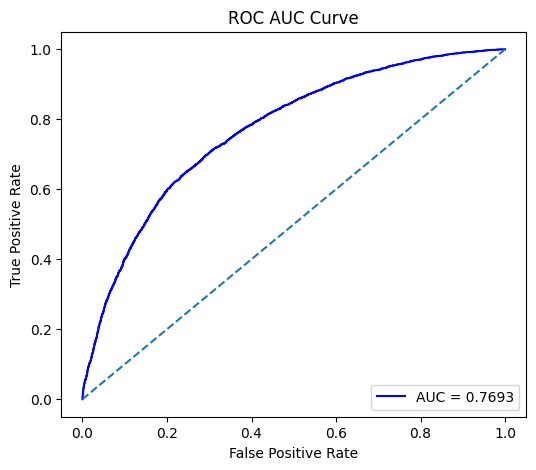

In [45]:
# Compute ROC Curve and AUC
fpr, tpr, _ = roc_curve(Y_test, y_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curve")
plt.legend(loc="lower right")
plt.show()

### Movie Recommender

This is a function that recommends movies to users given the `userId`.
* Finds all the unseen movies of the user.
* Predicts the user cluster as we have seen above.
* Fetches the movie metadata for each unseen movie (genres, decade).
* Runs the model predictions to calculate the prediction value for each unseen movie. The prediction values closer to 1.0 are for movies the user has high propability to like and those that will get recommended.

In [46]:
def recommend_movies(data, user_id, top_n=5):
    numerical = ["decade"]
    genres = ['IMAX', 'Animation', 'Film-Noir', 'Children', 'Romance', 'Western', 'Horror', 'War', 'Drama', 'Crime', 'Documentary', 'Sci-Fi', 'Musical', 'Mystery', 'Adventure', 'Action', 'Thriller', 'Comedy', 'Fantasy']
    
    # Exclude movies the user has already seen
    seen_movies = set(data.loc[data["userId"] == user_id, "movieId"])
    all_movie_ids = data["movieId"].unique()
    unseen_movies = np.array([m for m in all_movie_ids if m not in seen_movies])
    
    # Get movies' information (genres, decade)
    movie_metadata = (
        data.loc[data["movieId"].isin(unseen_movies), ["movieId"] + numerical + genres]
        .drop_duplicates(subset=["movieId"])
        .reindex(unseen_movies)
        .copy()
    )
    
    # Predict cluster for the user
    movie_metadata["cluster"] = predict_cluster_from_embedding(user_id)
    
    # Scale the decase
    movie_metadata[numerical] = scaler.transform(movie_metadata[numerical])

    # Predict classifier propabilities for recommendations
    predictions = model.predict([
        np.array([user_id] * len(unseen_movies)), 
        unseen_movies, 
        movie_metadata[numerical + ["cluster"]].to_numpy(),
        movie_metadata[genres].to_numpy()
    ])
    
    # Get top-N recommendations
    sorted_indices = np.argsort(predictions.flatten())[-top_n:][::-1]
    recommended_movies = unseen_movies[sorted_indices]
    
    return recommended_movies

Now we will an example of what will our recommender recommend to user 175 as top 5 movies and what movies this user has rated with 3.5 or more in the past. We will notice that some recommendations are good because the movies match in the genres and the decade features, considering the user's past highest rated movies.

In [47]:
user_id = 175
recommended_movies = recommend_movies(data, user_id=user_id)
recommended_movies_original_id = []
for movieId in recommended_movies:
    recommended_movies_original_id.append(int(movie_dictionary[movieId]))

unprocessed_data_unique_movies = unprocessed_data.drop_duplicates(subset=["movieId"])
print(f"Recommended movies for User {user_id}:")
for movie_id in recommended_movies_original_id:
    movie = unprocessed_data_unique_movies.loc[unprocessed_data_unique_movies["movieId"] == movie_id, ["title", "genres"]]
    print(movie.to_string(index=False))
    print("-" * 80)
    
print(f"\n\nWhat the user {user_id} liked in the past:")
unprocessed_data.loc[(unprocessed_data["userId"] == user_id) & (unprocessed_data["rating"] >= 3.5)]

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step
Recommended movies for User 175:
       title                      genres
Fargo (1996) Comedy|Crime|Drama|Thriller
--------------------------------------------------------------------------------
                       title                     genres
Three Caballeros, The (1945) Animation|Children|Musical
--------------------------------------------------------------------------------
                          title                     genres
Escape to Witch Mountain (1975) Adventure|Children|Fantasy
--------------------------------------------------------------------------------
                              title genres
Mr. Smith Goes to Washington (1939)  Drama
--------------------------------------------------------------------------------
          title       genres
Swingers (1996) Comedy|Drama
--------------------------------------------------------------------------------


What the user 175 liked in the past:


,userId,movieId,rating,title,genres
25211,175,531,3.5,"Secret Garden, The (1993)",Children|Drama
25213,175,2300,4.0,"Producers, The (1968)",Comedy
25215,175,3594,5.0,Center Stage (2000),Drama|Musical
25216,175,3791,5.0,Footloose (1984),Drama
25217,175,3969,4.5,Pay It Forward (2000),Drama
25219,175,7169,5.0,Chasing Liberty (2004),Comedy|Romance
25220,175,7259,3.5,You Got Served (2004),Drama|Musical
25221,175,8362,3.5,Raising Helen (2004),Comedy|Drama|Romance
25222,175,8643,4.5,"Cinderella Story, A (2004)",Comedy|Romance
25223,175,8911,5.0,Raise Your Voice (2004),Romance


# A.I Movie Recommender
In this project I used deep neural-networks to train a classifier model that will be able to tell if a user will like a movie or not and recommend movies to users based on their past ratings. The point and the fun of this project is making a movie recommendation system, do not bother with the metrics too much 😊. 

* The recommendation function is also provided inside the notebook where someone can change the `userId` in the last cell and get recommendations for another user.
* You can also add YOUR recommendations into the dataset and play around. What movies will the system will recommend you? 😎

## 🛠️ Installation / Run
You can download, open and run the jupyter notebook in any platform that supports it. You will also need to install tensorflow, numpy and pandas for python. The dataset is in the link below.

## 📝 Dataset
Used the popular MovieLens 100k dataset from https://grouplens.org/datasets/movielens/latest/

## 🔄 Data Pre-Processing
The data pre-processing stage involves multiple modifications like one-hot encodings, transforming, normalization, cleanup and scaling of the data.

## 🔠 Clustering
    ▶️Clustering Function: HDBSCAN
    ▶️Minimum Cluster Size: 20
### Metrics:
```
✅Silhouette Score: 0.42885184579313873
✅Davies-Bouldin Index Score: 0.8235000921376852 
✅Number of Clusters: 193
✅Noise: 23%
```

## 📎 Neural Network
### Classifier
    ▶️Embedding Layers: 2 (User embedding & Movie Embedding)
    ▶️Embedding Dimensions: 16, 8
    ▶️Neuron Layers: 2
    ▶️Size of Neuron Layers: 16 -> 8 -> 1(output)
    ▶️Dropout Layers: 30% (16)
    ▶️Learning Rate: 0.0001
    ▶️Loss Function: Cross Entropy Loss  
    ▶️Optimizer: Adam
    ▶️Batch size: 32
    ▶️Epochs: 50
    ▶️Also used:  feature extraction, feature normalization, built-in sigmoid function
### Metrics:
```
✅Accuracy: ~71%
✅AUC: 0.7693
```
    
 ## Built With
<p float="left">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/Python-logo-notext.svg/110px-Python-logo-notext.svg.png" alt="MarineGEO circle logo" style="height: 100px; width:100px;"/>  
 </p>
